<a href="https://colab.research.google.com/github/dalopez994/LPQ-HR/blob/main/LPQ_ML_Lopez_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Librerias
!pip install scikit-plot 
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import scale, MinMaxScaler
import seaborn as sns
import numpy as np 
from datetime import datetime
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
URL = 'https://docs.google.com/spreadsheets/d/1sJArkK2eoDSkPZk4rlCCuq0i99nElMjm/edit?usp=sharing&ouid=103610186518311676983&rtpof=true&sd=true'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
df_nomina = pd.read_excel(path)
df_nomina['Fecha de egreso de último tramo'] = df_nomina['Fecha de egreso de último tramo'].fillna(pd.to_datetime('today'))
df_nomina=df_nomina.assign(Antiguedad=lambda x: ((x['Fecha de egreso de último tramo'] - x['Fecha de ingreso de último tramo'])).astype('<m8[Y]').astype(int) )
df_nomina=df_nomina.assign(Edad=lambda x: (pd.Timestamp.today() - x['Fecha de nacimiento']).astype('<m8[Y]').astype(int) )


In [3]:
#Variables categoricas a numericas
df_nomina['cod_sexo']=df_nomina['Sexo'].astype('category').cat.codes
df_nomina['cod_nacionalidad']=df_nomina['Nacionalidad'].astype('category').cat.codes
df_nomina['cod_estado_civil']=df_nomina['Estado civil'].astype('category').cat.codes

In [4]:
df_nomina.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 48 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Número                                    170 non-null    float64       
 1   Apellido                                  170 non-null    object        
 2   Nombre                                    170 non-null    object        
 3   Condición                                 170 non-null    object        
 4   Código de convenio                        170 non-null    object        
 5   Código de categoría                       170 non-null    object        
 6   Código de departamento                    170 non-null    object        
 7   Descripción de departamento               170 non-null    object        
 8   Código de lugar de trabajo                170 non-null    object        
 9   Descripción de lugar de trabajo 

In [5]:
#Filtro datos que entraran en el modelo
df_data=df_nomina.iloc[:, 31:48]
df_data.describe()

,Ambicioso,Expresivo,Sociable,Curioso,Enérgico,Flexible,Humilde,Apasionado,Positivo,Presentable,Promedio,Antiguedad,Edad,cod_sexo,cod_nacionalidad,cod_estado_civil
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,1.741176,2.088235,2.435294,2.023529,2.217647,2.311765,2.352941,1.876471,2.141176,2.558824,2.174706,1.317647,26.835294,0.358824,0.852941,0.976471
std,0.986932,0.882695,0.820551,0.876740,0.824718,0.865090,0.944694,0.871664,0.851771,0.737466,0.522518,2.225255,6.174671,0.481072,1.722327,0.216288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,18.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.900000,0.000000,22.000000,0.000000,0.000000,1.000000
50%,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.200000,0.000000,26.000000,0.000000,0.000000,1.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.600000,2.000000,30.000000,1.000000,0.750000,1.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,9.000000,51.000000,1.000000,5.000000,2.000000


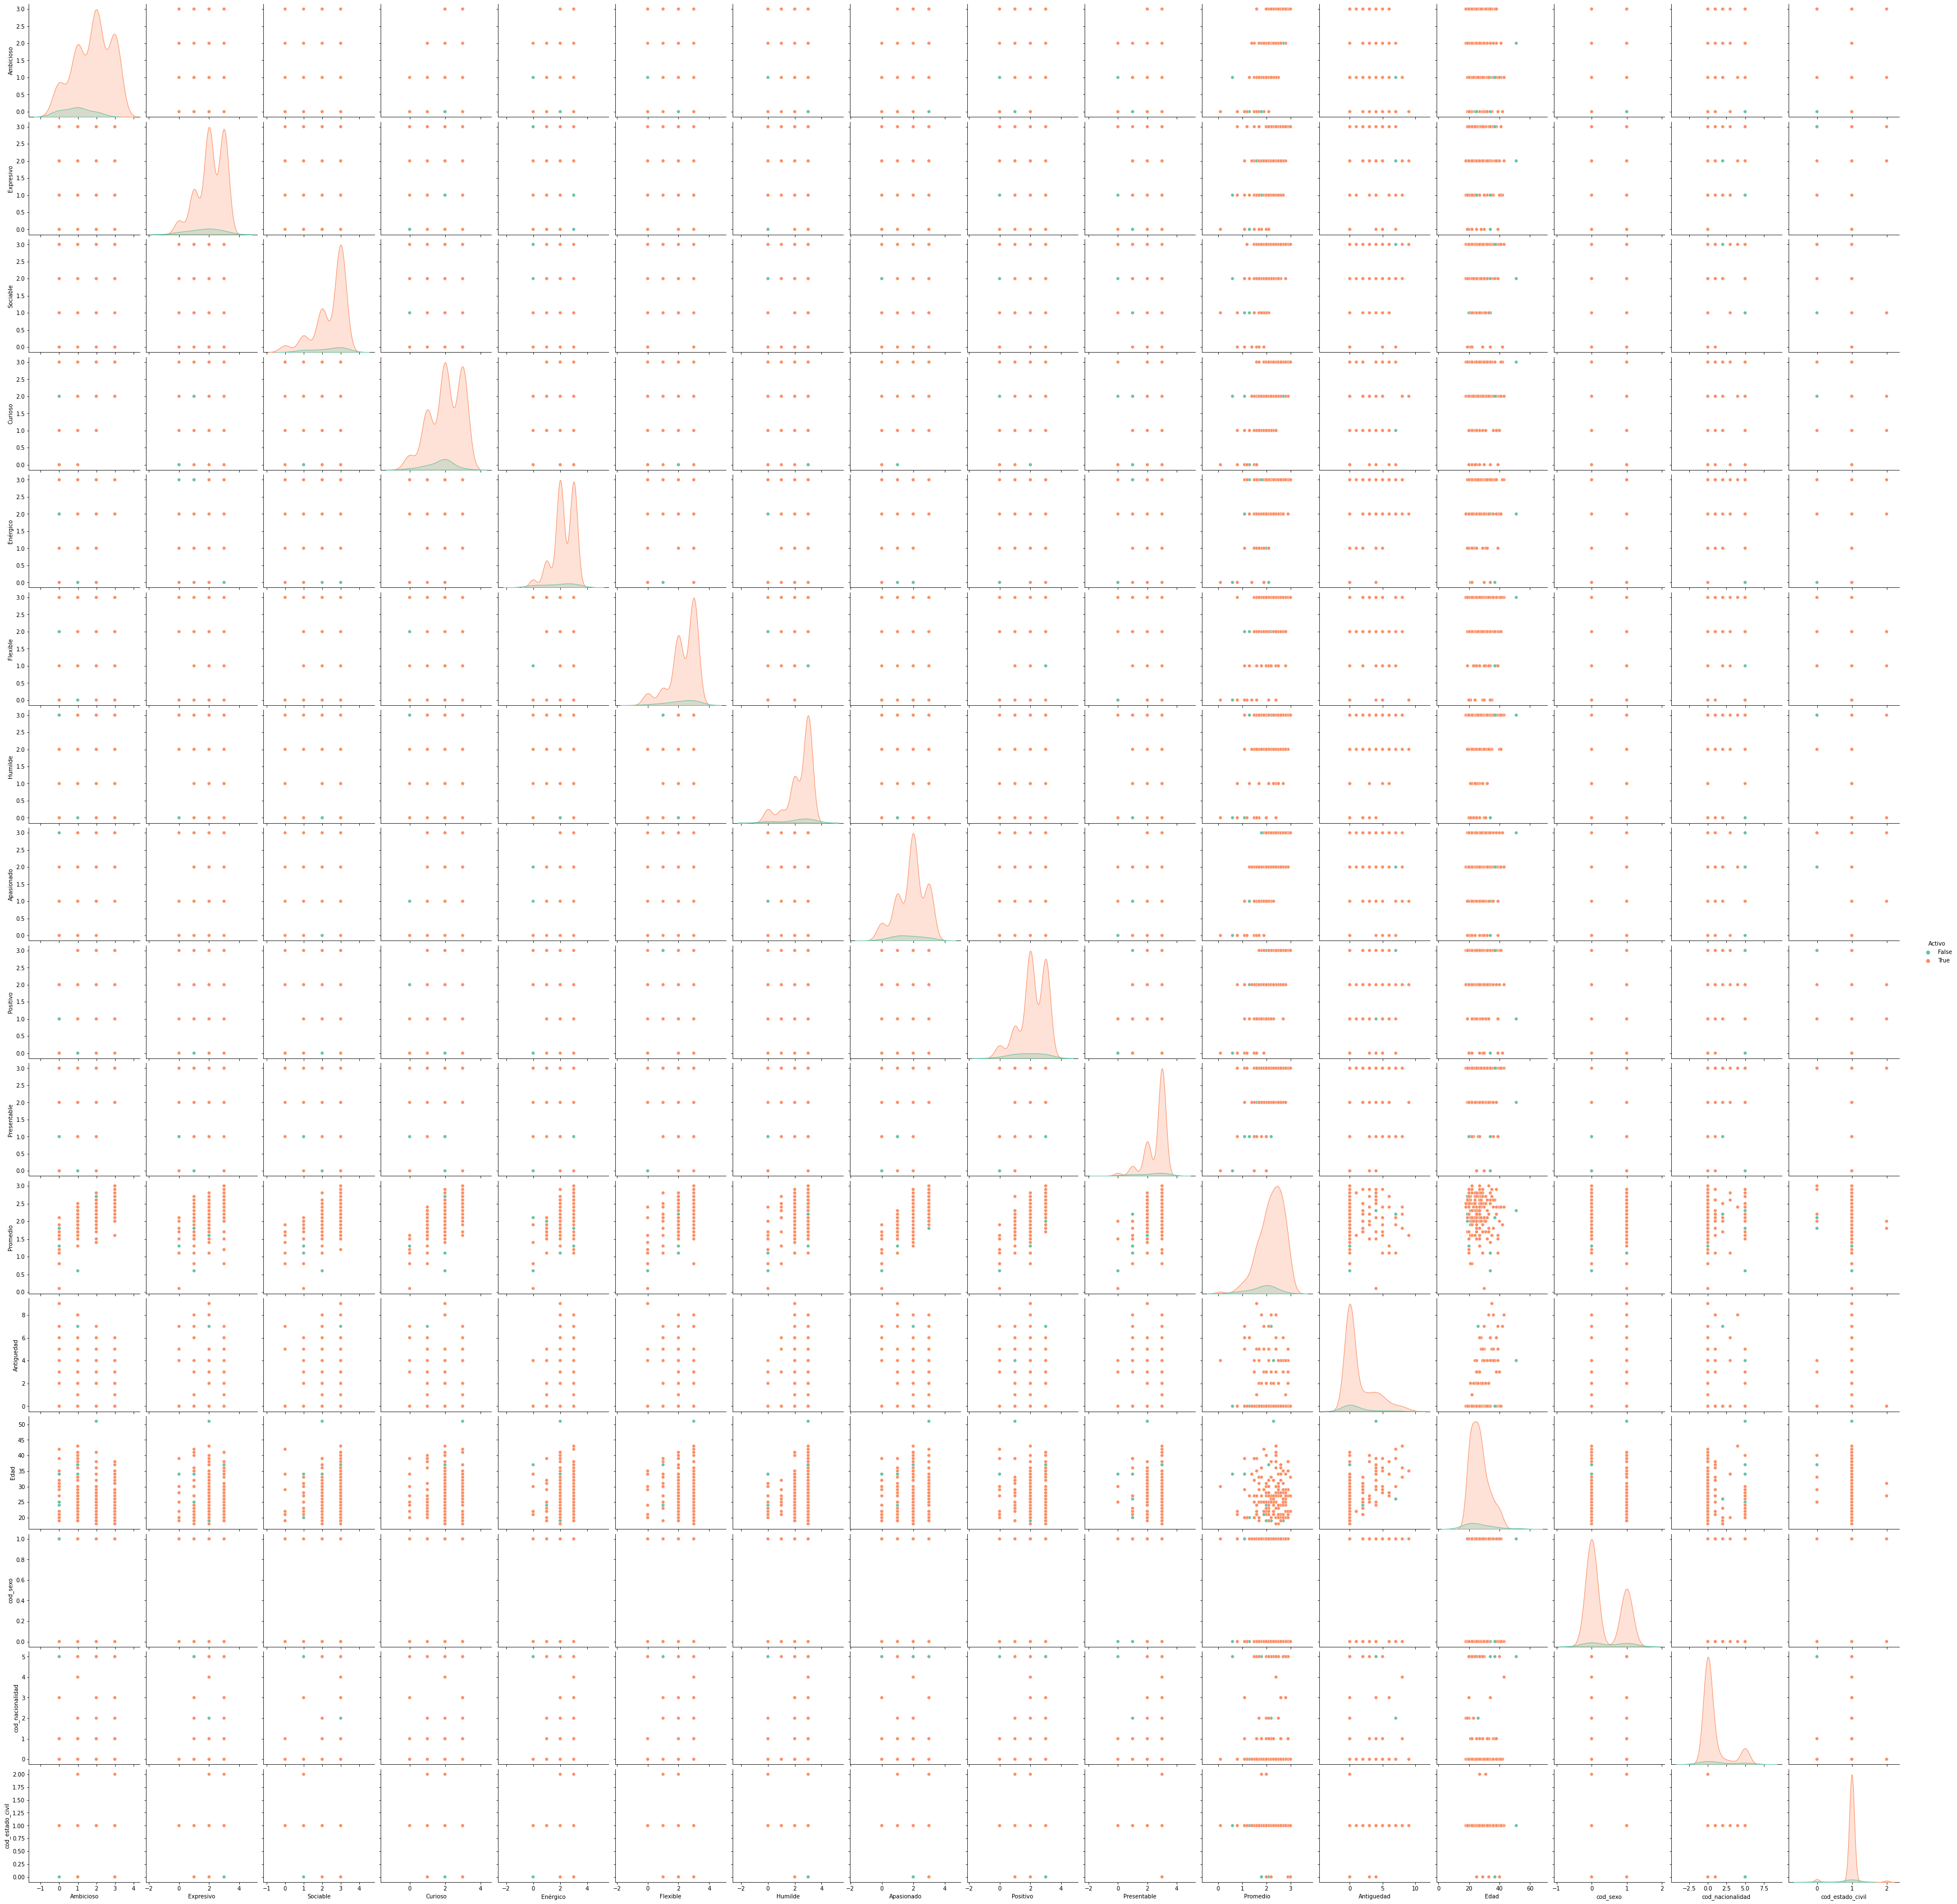

In [ ]:
#Pairplot
sns.pairplot(df_data,hue = 'Activo' , height = 3 , palette = 'Set2')

In [12]:
#Se definen las variables
X = df_data.drop(["Activo","Promedio"], axis=1)
y = df_data["Activo"]

#Se escalan los datos
x= scale(X)

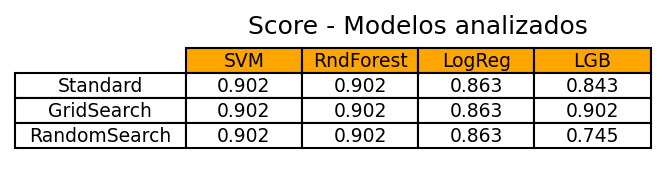

In [17]:
#@title GRID - Modelos
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.70,test_size=0.30,random_state=0)

#Dataframe de resultados
cols = ['Case','SVM','RndForest','LogReg','LGB']
resul = pd.DataFrame(columns=cols)
resul.set_index("Case",inplace=True)
resul.loc['Standard'] = [0,0,0,0]
resul.loc['GridSearch'] = [0,0,0,0]
resul.loc['RandomSearch'] = [0,0,0,0]

#Creación de Modelos

svc   = SVC(gamma='auto')
rf    = RandomForestClassifier(n_estimators=10)
lr    =  LogisticRegression(solver='liblinear')
lgg   = lgb.LGBMClassifier()
models = [svc,rf,lr,lgg]

col = 0
for model in models:
    model.fit(X_train,y_train.values.ravel())
    resul.iloc[0,col] = model.score(X_valid,y_valid).round(3)
    col += 1

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


#Support Vector Classifier
kernel = ['poly', 'rbf']#, 'sigmoid'
C = [0.1, 0.01]#50, 10, 1.0, 
gamma = ['scale']
svc_grid = dict(kernel=kernel,C=C,gamma=gamma)


#Random Forest
n_estimators = [10, 100]#, 1000,10000
max_features = ['sqrt', 'log2']
rf_grid = dict(n_estimators=n_estimators,max_features=max_features)

#Logistic Regression
solvers = ['newton-cg']#, 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [ 1.0, 0.1, 0.01]#100, 10,
lr_grid = dict(solver=solvers,penalty=penalty,C=c_values)

#LGB
class_weight = [None,'balanced']
boosting_type = ['gbdt']# 'goss', 'dart'
num_leaves = [30,50] #list(range(30, 150)),
learning_rate = list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)) #1000
lgg_grid = dict(class_weight=class_weight, boosting_type=boosting_type, num_leaves=num_leaves, learning_rate =learning_rate)

#GRID SEARCH
models = [svc,rf,lr,lgg]
grids = [svc_grid,rf_grid,lr_grid,lgg_grid]
col = 0

for ind in range(0,len(models)):
    cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3,random_state=1)
    grid_search = GridSearchCV(estimator=models[col], 
                  param_grid=grids[col], n_jobs=-1, cv=cv,  
                  scoring='accuracy',error_score=0)
    grid_clf_acc = grid_search.fit(X_train, y_train)
    resul.iloc[1,col] = grid_clf_acc.score(X_valid,y_valid).round(3)
    col += 1

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
col = 0
for ind in range(0,len(models)):
    cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, 
                                 random_state=1)
    n_iter_search = 3
    random_search = RandomizedSearchCV(models[col],
    param_distributions=grids[col],n_iter=n_iter_search, cv=cv)
    random_search.fit(X_train,y_train)
    resul.iloc[2,col] = random_search.score(X_valid,y_valid).round(3)
    col += 1
    
fig, ax =plt.subplots(dpi=150,figsize=(4,1))
plt.title('Score - Modelos analizados')

ax.axis('off')

the_table = ax.table(cellText=resul.values,rowLabels=resul.index,colLabels=resul.columns,rowLoc='center',cellLoc='center',loc='upper center',colColours =["orange"] * 4,)

[[ 2  3]
 [ 4 42]]
Best: 0.934921 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


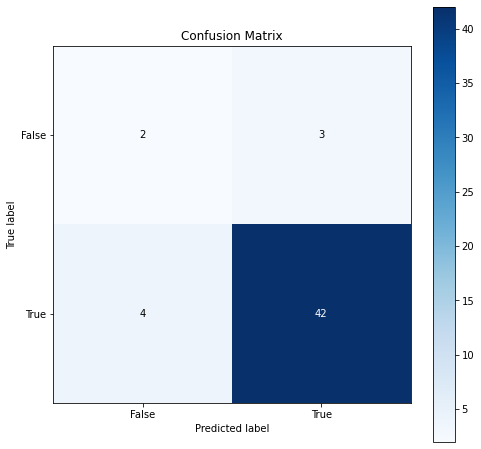

In [ ]:
#@title Confusion Matrix - LogReg
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3,  
                             random_state=1)
n_iter_search = 3
grid_search = GridSearchCV(estimator=lr, param_grid=lr_grid, 
              n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_win = grid_search.fit(X_train, y_train)

#Valores predichos basados en los nuevos parametros
yv_pred = grid_win.predict(X_valid)

print(confusion_matrix(y_valid, yv_pred))
skplt.metrics.plot_confusion_matrix(y_valid, yv_pred,figsize=(8,8))
print("Best: %f using %s" % (grid_win.best_score_, grid_win.best_params_))

[[ 0  5]
 [ 0 46]]
Best: 0.932143 using {'max_features': 'sqrt', 'n_estimators': 100}


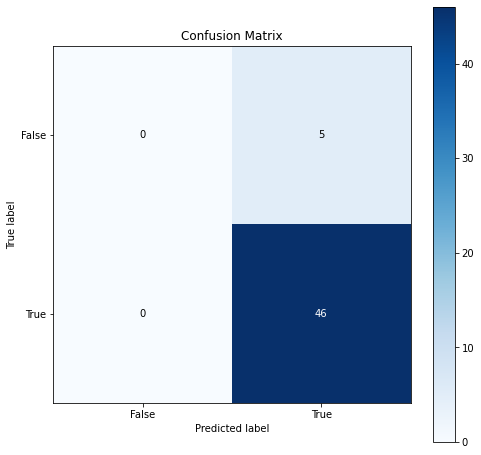

In [ ]:
#@title Confusion Matrix - RndForest
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3,  
                             random_state=1)
n_iter_search = 3
grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid, 
              n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_win = grid_search.fit(X_train, y_train)

#Valores predichos basados en los nuevos parametros
yv_pred = grid_win.predict(X_valid)

print(confusion_matrix(y_valid, yv_pred))
skplt.metrics.plot_confusion_matrix(y_valid, yv_pred,figsize=(8,8))

print("Best: %f using %s" % (grid_win.best_score_, grid_win.best_params_))